In [14]:
# Imports 

import sys
import time
import os
import warnings

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import fitsio
from astropy.io import fits

sys.path.insert(0, '/home/bekah/gphoton_working')
sys.path.insert(0, '/home/bekah/gphoton_working/gPhoton')

import pandas as pd 

from pyarrow import parquet

from gPhoton.parquet_utils import parquet_to_ndarray

from astropy.table import Table

from gPhoton.aspect import load_aspect_solution

from gPhoton.io.raw6 import load_raw6

from gPhoton.io._query.mast_query import retrieve_aspect
from gPhoton.io.mast import get_raw_paths 

In [2]:
def centile_clip(image, centiles=(0, 90)):
    """
    simple clipping function that clips values above and below a given
    percentile range
    """
    finite = np.ma.masked_invalid(image)
    bounds = np.percentile(finite[~finite.mask].data, centiles)
    result = np.ma.clip(finite, *bounds)
    
    if isinstance(image, np.ma.MaskedArray):
        
        return result
    
    return result.data

In [15]:
# loading aspect table 
parq  = parquet.read_table('/home/bekah/gphoton_working/gPhoton/aspect/aspect.parquet')
aspect = parq.to_pandas()
# boresight parquet 
parq  = parquet.read_table('/home/bekah/gphoton_working/gPhoton/aspect/boresight.parquet')
bore = parq.to_pandas()

/tmp/ipykernel_4126/679291431.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vector_table["ra_diff"] = vector_table.diff()['ra']
/tmp/ipykernel_4126/679291431.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vector_table["dec_diff"] = vector_table.diff()['dec']
/tmp/ipykernel_4126/679291431.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

<IPython.core.display.Javascript object>


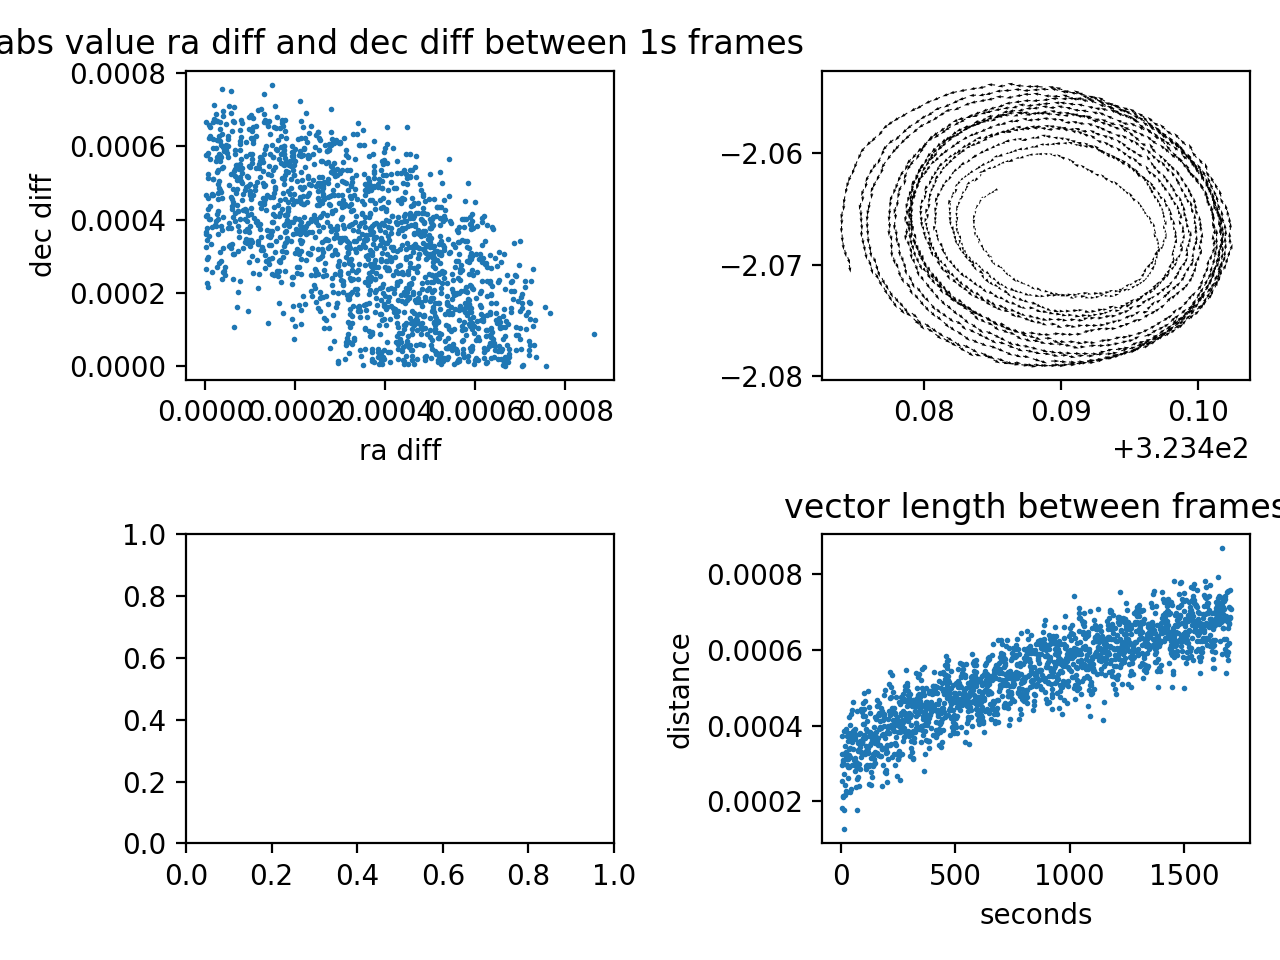

In [6]:
# plotting vectors between frames 

vector_table = calculate_vector(23456)
vector_table

%matplotlib notebook

# vector plots 

fig, ax = plt.subplots(2,2)

ax[0,0].scatter(abs(vector_table['ra_diff']),abs(vector_table['dec_diff']),s=1)
ax[0,0].set_title("abs value ra diff and dec diff between 1s frames")
ax[0,0].set_xlabel('ra diff')
ax[0,0].set_ylabel('dec diff')

ax[1,1].scatter(vector_table.index,vector_table['vector_length'],s=1)
ax[1,1].set_title("vector length between frames")
ax[1,1].set_xlabel('seconds')
ax[1,1].set_ylabel('distance')

ax[0,1].quiver(vector_table['ra'],vector_table['dec'],vector_table['ra_diff'],vector_table['dec_diff'])

fig.tight_layout()

In [4]:
# for whole aspect table stats 

# tl;dr what I learned is all the distances are pretty short albeit not exactly consistent (fault of aspect soln 
# or fault of machine? we shall never know...)

def get_all_vector_lengths():
    parq  = parquet.read_table('/home/bekah/gphoton_working/gPhoton/aspect/aspect.parquet')
    vector_table = parq.to_pandas()
    vector_table["ra_diff"] = vector_table.diff()['ra']
    vector_table["dec_diff"] = vector_table.diff()['dec']
    vector_table["roll_diff"] = vector_table.diff()['roll']
    vector_table["vector_length"] = (vector_table["dec_diff"]**2 + vector_table["ra_diff"]**2)**.5
    
    return vector_table 

#vector_table = get_all_vector_lengths()

#plt.scatter(vector_table['time'][0:1000],vector_table['vector_length'][0:1000])

In [5]:


def run_crossmatch(eclipse, frame):
    if frame == 0: 
        # no prior frame to crossmatch with 
        return 
    else: 
        vector_table = calculate_vector(2025)
        xylist_1 = load_xylist(eclipse, frame-1)
        xylist_2 = load_xylist(eclipse, frame)
        
        xylist_rev, search_zones = xylist_crossmatch(xylist_1, xylist_2, frame, vector_table) 
        return xylist_rev.T, search_zones


def calculate_vector(eclipse): 
    # loading aspect table 
    parq  = parquet.read_table('/home/bekah/gphoton_working/gPhoton/aspect/aspect.parquet')
    aspect = parq.to_pandas()
    vector_table = aspect.loc[aspect["eclipse"]==eclipse]
    vector_table["ra_diff"] = vector_table.diff()['ra']
    vector_table["dec_diff"] = vector_table.diff()['dec']
    vector_table["roll_diff"] = vector_table.diff()['roll']
    vector_table["vector_length"] = (vector_table["dec_diff"]**2 + vector_table["ra_diff"]**2)**.5
    return vector_table.reset_index()


def load_xylist(eclipse, frame):
    xylist = fits.open(f'/home/bekah/gphoton_working/test_data/e{eclipse}/frame{frame}_1s_e{eclipse}.xyls')
    xytable = Table.read(xylist)
    xytable = xytable.to_pandas()

    return xytable 


def xylist_crossmatch(xylist_1, xylist_2, frame, vector_table): 
    """compare two frames"""
    # new df for revised xylist 2 
    xylist_2_rev = pd.DataFrame()
    
    search_zones = wedge_search_area(xylist_1, frame, vector_table)
    for index, zone in search_zones.iterrows():
        for index2, point in xylist_2.iterrows(): 
            if in_box(zone, point):
                print(point)
                xylist_2_rev = pd.concat([xylist_2_rev,point],axis=1)
    return xylist_2_rev, search_zones


def wedge_search_area(xylist_1, frame, vector_table):
    """define search area for cross-matching xylist points using motion vector """
    search_zones = pd.DataFrame()
    search_zones['X1'] = xylist_1['X']
    search_zones['Y1'] = xylist_1['Y']
    # search zone 
    search_zones['X2'] = xylist_1['X'] + vector_table["ra_diff"][frame]*10000
    search_zones['Y2'] = xylist_1['Y'] + vector_table["dec_diff"][frame]*10000
    
    return search_zones 
    

def in_box(zone, point):
    top_left_x = min(zone['X1'], zone['X2'])
    top_left_y = max(zone['Y1'], zone['Y2'])
    bottom_right_x = max(zone['X1'], zone['X2'])
    bottom_right_y = min(zone['Y1'], zone['Y2'])
    #print(top_left_x)
    #print(bottom_right_x)
    #print(top_left_y)
    #print(bottom_right_y)

    return ((top_left_x >= point['X']) & (point['X'] >= bottom_right_x)
        & (point['Y'] <= top_left_y) & (point['Y'] >= bottom_right_y))


/tmp/ipykernel_4126/679291431.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vector_table["ra_diff"] = vector_table.diff()['ra']
/tmp/ipykernel_4126/679291431.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vector_table["dec_diff"] = vector_table.diff()['dec']
/tmp/ipykernel_4126/679291431.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

<IPython.core.display.Javascript object>


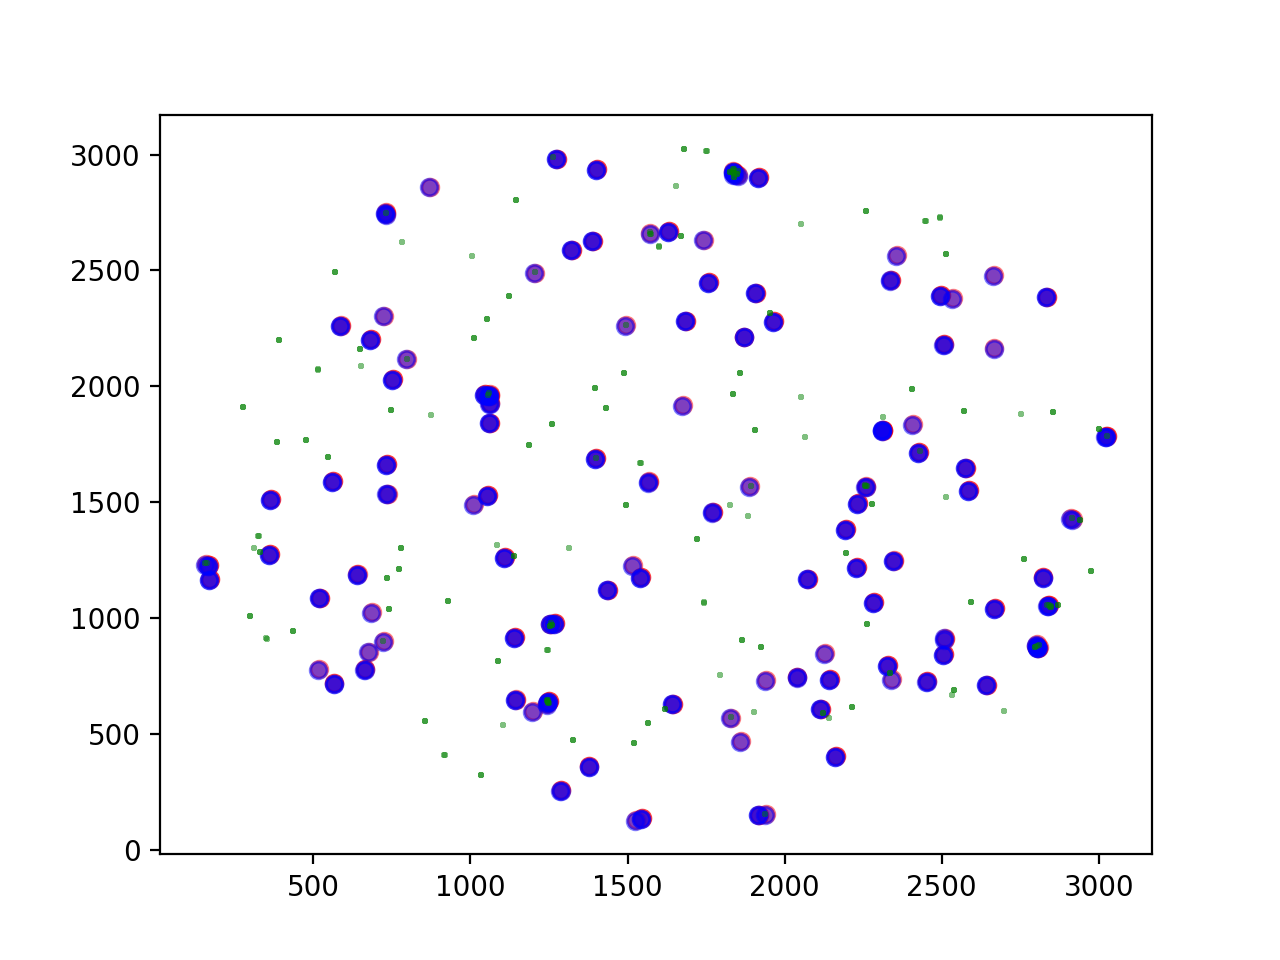

In [7]:
xylist, search_zones = run_crossmatch('09869', 154)
plt.scatter(search_zones['X1'],search_zones['Y1'],c='red',alpha=.5)
plt.scatter(search_zones['X2'],search_zones['Y2'],c='blue',alpha=.5)

eclipse = '09869'
frame = '155'
xylist = fits.open(f'/home/bekah/gphoton_working/test_data/e{eclipse}/frame{frame}_1s_e{eclipse}.xyls')
xytable = Table.read(xylist)
xytable = xytable.to_pandas()
plt.scatter(xytable['X'],xytable['Y'],c='green',alpha=.5,marker='+',s=5)


<IPython.core.display.Javascript object>


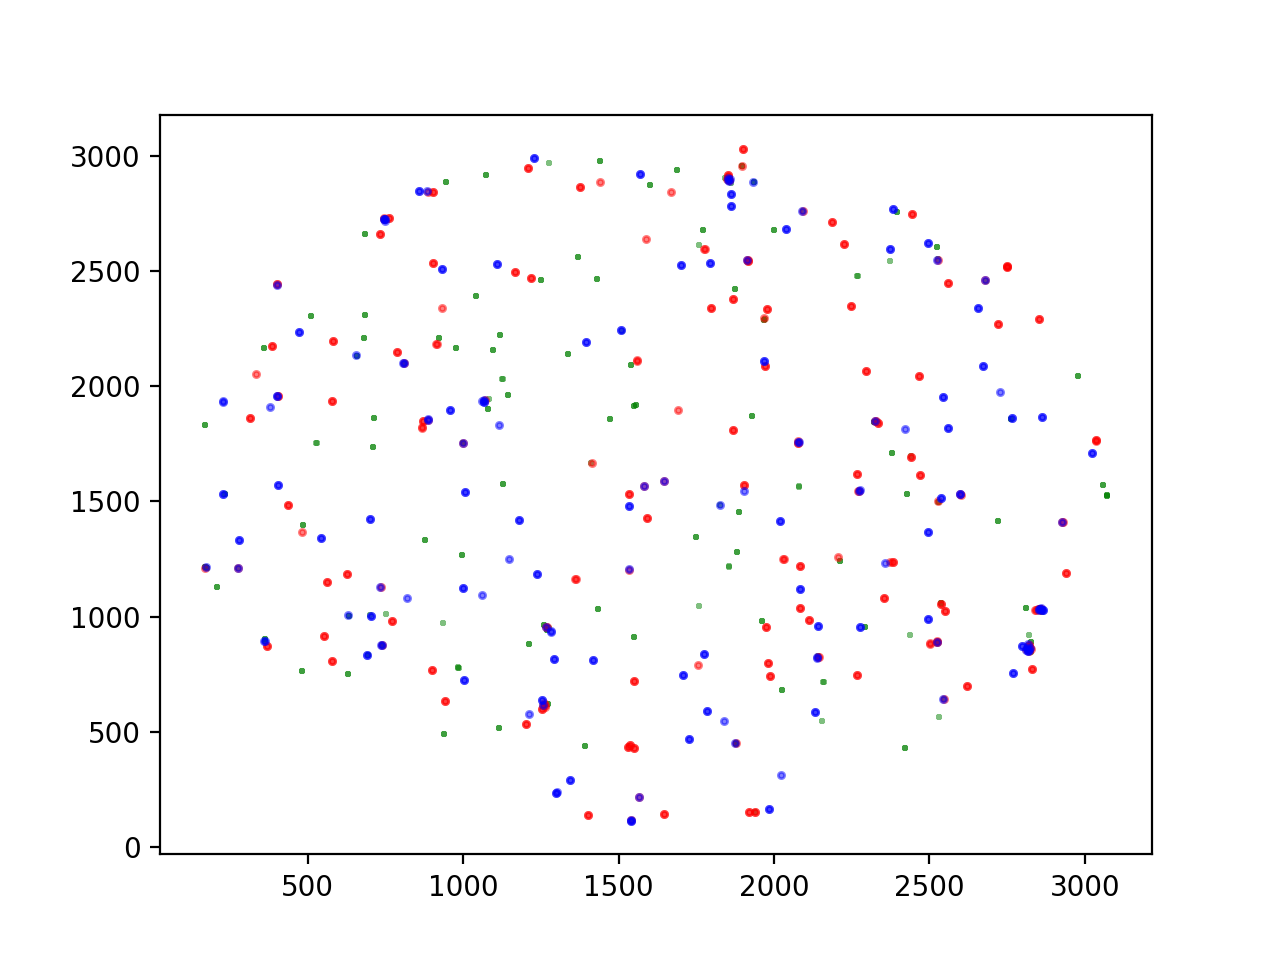

In [10]:
#plt.scatter(search_zones.T['X'],search_zones.T['Y'],alpha=.5)

eclipse = '09869'
frame = '120'
xylist = fits.open(f'/home/bekah/gphoton_working/test_data/e{eclipse}/frame{frame}_1s_e{eclipse}.xyls')
xytable = Table.read(xylist)
xytable = xytable.to_pandas()
plt.scatter(xytable['X'],xytable['Y'],c='green',alpha=.5,marker='+',s=5)
xylist2 = fits.open(f'/home/bekah/gphoton_working/test_data/e{eclipse}/frame121_1s_e{eclipse}.xyls')
xytable2 = Table.read(xylist2)
xytable2 = xytable2.to_pandas()
plt.scatter(xytable2['X'],xytable2['Y'],c='red',alpha=.5,marker='o',s=5)
xylist3 = fits.open(f'/home/bekah/gphoton_working/test_data/e{eclipse}/frame122_1s_e{eclipse}.xyls')
xytable3 = Table.read(xylist3)
xytable3 = xytable3.to_pandas()
plt.scatter(xytable3['X'],xytable3['Y'],c='blue',alpha=.5,marker='o',s=5)

xytable['frame']=120
xytable2['frame']=121
xytable3['frame']=122
combo_frmes = pd.concat([xytable,xytable2,xytable3])

In [ ]:
combo_frmes

<IPython.core.display.Javascript object>


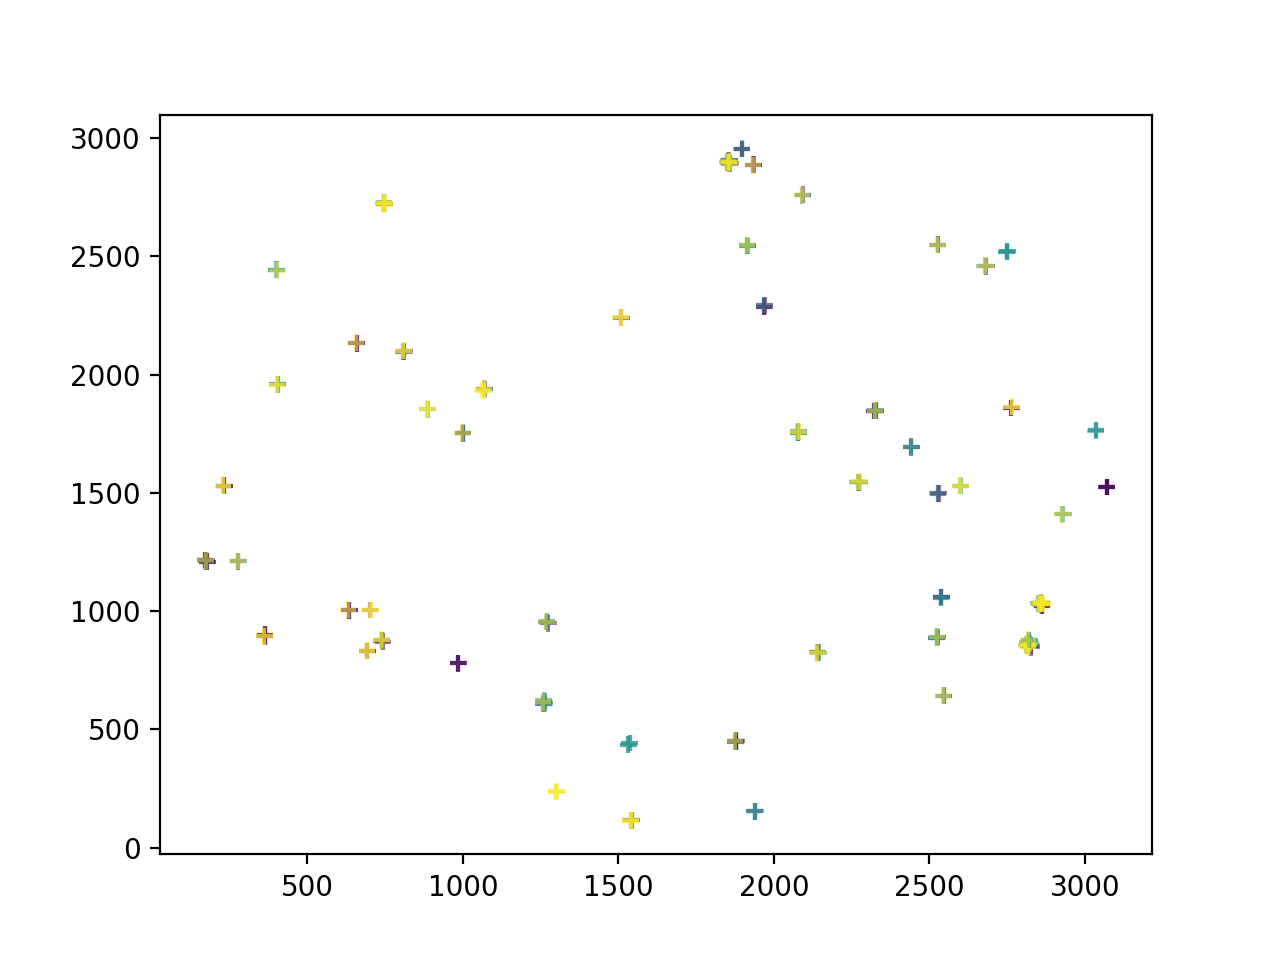

In [13]:
from photutils.psf.groupstars import DBSCANGroup
from astropy.table import QTable, Table, Column 

starlist = Table()

starlist['x_0'] = combo_frmes['X']
starlist['y_0'] = combo_frmes['Y']
starlist['frame'] = combo_frmes['frame']

dbscan_group = DBSCANGroup(crit_separation=8)

dbsc_star_groups = dbscan_group(starlist)

dbsc_star_groups_pd = dbsc_star_groups.to_pandas().groupby(['group_id'])

dbsc_star_groups = dbsc_star_groups.group_by('group_id')

shortened_xylist = pd.DataFrame()

for i, group in enumerate(dbsc_star_groups.groups):
    if len(group) > 2:
        shortened_xylist = pd.concat([shortened_xylist,group.to_pandas()])

plt.scatter(shortened_xylist['x_0'],shortened_xylist['y_0'],c=shortened_xylist['frame'],marker='+',alpha=0.5)
#dbsc_star_groups_count = dbsc_star_groups_pd.size()

#twomin = dbsc_star_groups_count[dbsc_star_groups_count>=2]

#dbsc_star_groups['group_id'].loc(twomin.index)

In [ ]:
# how to put a kind of buffer zone around each point? 



In [12]:
from photutils.psf.groupstars import DBSCANGroup
from astropy.table import QTable, Table, Column 


def clean_frames(eclipse, num_frames):
    x = 0 
    while x+3 < num_frames: 
        frames = [x, x+1, x+2]
        
        combined_frames = combine_frames(eclipse, frames)
        
        cleaned_xylist = group_xylists(combined_frames)
        
        cleaned_xylist = cleaned_xylist.groupby(['frame'])
        
        for i, group in enumerate(cleaned_xylist.groups):
            print(group)
            frame = group['frame']
            make_fits_table(group, eclipse, frame)

        x = x+3 

        
def combine_frames(eclipse, frames): 
    combo_frames = pd.DataFrame()
    for frame in frames: 
        xylist = fits.open(f'/home/bekah/gphoton_working/test_data/e{eclipse}/frame{frame}_1s_e{eclipse}.xyls')
        xytable = Table.read(xylist)
        xytable = xytable.to_pandas()
        xytable['frame']=frame
        combo_frames = pd.concat([combo_frames,xytable])
    return combo_frames 

        
def group_xylists(combo_frmes): 
    starlist = Table()

    starlist['x_0'] = combo_frmes['X']
    starlist['y_0'] = combo_frmes['Y']
    starlist['frame'] = combo_frmes['frame']

    dbscan_group = DBSCANGroup(crit_separation=8)

    dbsc_star_groups = dbscan_group(starlist)

    dbsc_star_groups_pd = dbsc_star_groups.to_pandas().groupby(['group_id'])

    dbsc_star_groups = dbsc_star_groups.group_by('group_id')

    shortened_xylist = pd.DataFrame()

    for i, group in enumerate(dbsc_star_groups.groups):
        if len(group) > 2:
            shortened_xylist = pd.concat([shortened_xylist,group.to_pandas()])
            
    return shortened_xylist 
            
def make_fits_table(star_list, eclipse, frame):
    """ writes fits table of source locations, sorted by flux (highest flux = first)"""
    print("making fits table of xy positions")
    star_list = star_list.sort_values(by="flux", ascending=False)
    colx = fits.Column(name='X', format='E', array=star_list['xcentroid'])
    coly = fits.Column(name='Y', format='E', array=star_list['ycentroid'])
    hdu = fits.BinTableHDU.from_columns([colx, coly])
    tableName = f'/home/bekah/gphoton_working/test_data/e{eclipse}/frame{frame}_clean.xyls'
    hdu.writeto(tableName, overwrite=True)
    return 

clean_frames('09869',185)

0


TypeError: 'int' object is not subscriptable

In [2]:
import pandas as pd
df = pd.read_csv('/home/bekah/glcat/astrometry/aspect_correction/astrometry_xy_tycho_5s_02025')

In [12]:
df.keys()

Index(['frame', 'crpix0', 'crpix1', 'crval1', 'crval0', 'ra_tangent',
       'dec_tangent', 'pixx_tangent', 'pixy_tangent', 'imagew', 'imageh',
       'cd11', 'cd12', 'cd21', 'cd22', 'det', 'parity', 'pixscale',
       'orientation', 'ra_center', 'dec_center', 'orientation_center',
       'ra_center_h', 'ra_center_m', 'ra_center_s', 'dec_center_sign',
       'dec_center_d', 'dec_center_m', 'dec_center_s', 'ra_center_hms',
       'dec_center_dms', 'ra_center_merc', 'dec_center_merc', 'fieldarea',
       'fieldw', 'fieldh', 'fieldunits', 'decmin', 'decmax', 'ramin', 'ramax',
       'ra_min_merc', 'ra_max_merc', 'dec_min_merc', 'dec_max_merc',
       'merc_diff', 'merczoom', 'failed_flag'],
      dtype='object')

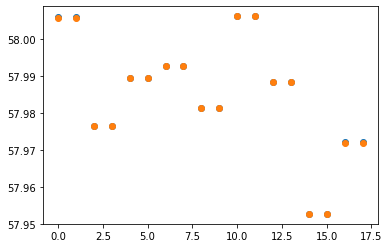

In [10]:
from matplotlib import pyplot as plt
plt.scatter(df.index,df['orientation'])
plt.scatter(df.index,df['orientation_center'])

In [5]:
df['orientation_center']

0     58.005787
1     58.005787
2     57.976380
3     57.976380
4     57.989475
5     57.989475
6     57.992677
7     57.992677
8     57.981245
9     57.981245
10    58.006109
11    58.006109
12    57.988429
13    57.988429
14    57.952662
15    57.952662
16    57.971970
17    57.971970
Name: orientation_center, dtype: float64

In [16]:
aspect

,eclipse,time,ra,dec,roll,flags
0,580,7.389973e+08,210.540477,-32.673776,0.001104,49
1,580,7.389973e+08,210.540048,-32.673958,0.001257,49
2,580,7.389973e+08,210.539618,-32.674159,0.001586,49
3,580,7.389973e+08,210.539168,-32.674489,0.002005,49
4,580,7.389973e+08,210.538610,-32.674799,0.002408,49
...,...,...,...,...,...,...
43094675,46834,1.012655e+09,180.598848,-19.820267,37.036690,64
43094676,46834,1.012655e+09,180.598884,-19.820535,37.036325,64
43094677,46834,1.012655e+09,180.599141,-19.820719,37.035851,64
43094678,46834,1.012655e+09,180.599371,-19.820848,37.035380,64
